In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import iirnotch, lfilter
import pickle


In [4]:
df = pd.read_excel('microfix/10.xlsx', sheet_name='10')
y = df['CH1']
x = df['CH2']
z = df['CH3']


In [4]:
#preprocessing signal ???
class HighPassFilter:
    def __init__(self, alpha):
        self.alpha = alpha
        self.last_input = 0.0
        self.last_output = 0.0

    def apply_filter(self, input):
        output = self.alpha * (self.last_output + input - self.last_input)
        self.last_input = input
        self.last_output = output
        return output

class LowPassFilter:
    def __init__(self, alpha, initial_value=0.00):
        self.alpha = alpha
        self.value = initial_value

    def update(self, new_value):
        self.value = self.alpha * new_value + (1 - self.alpha) * self.value
        return self.value

In [33]:
alpha = 0.01
highPassFilter = HighPassFilter(alpha)
beta = 0.99 # Adjust the alpha value based on your requirements
initial_value = 0  # Initial value of the filter
filter = LowPassFilter(beta, initial_value)
filtered_x = [highPassFilter.apply_filter(value) for value in z]
filtered_signal = [filter.update(value)*10 for value in filtered_x]


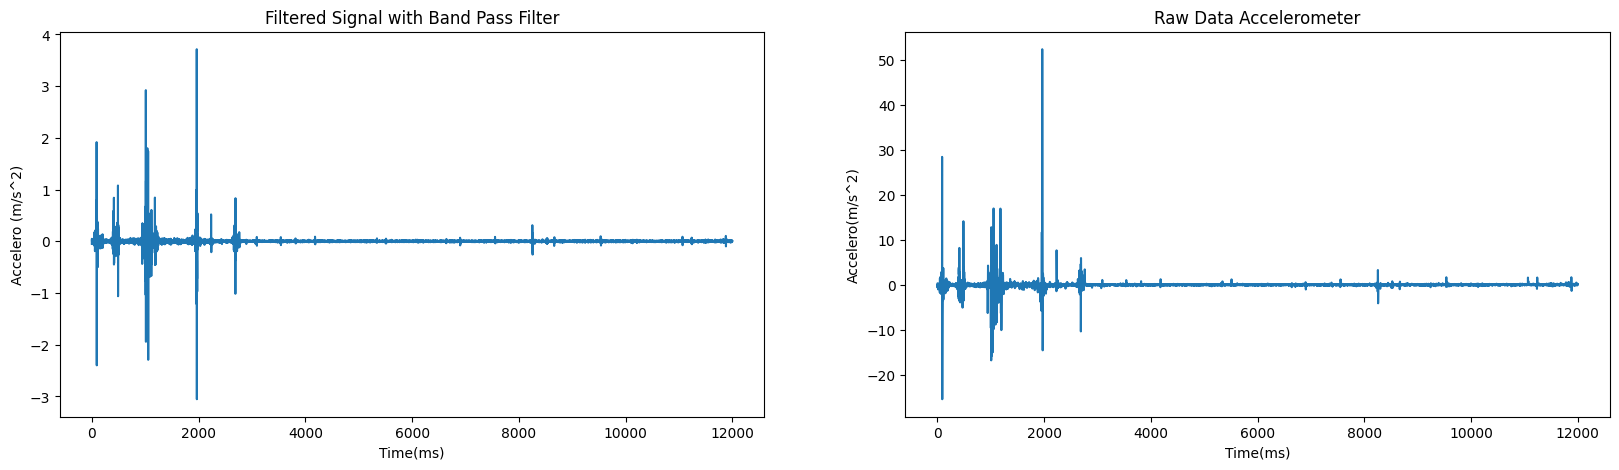

In [34]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot( filtered_signal)
plt.title('Filtered Signal with Band Pass Filter')
plt.xlabel('Time(ms)')
plt.ylabel('Accelero (m/s^2)')
plt.subplot(1,2,2)
plt.plot(z,label='raw data')
#plt.plot( filtered_signal,color='red',label='filtered')
plt.title('Raw Data Accelerometer')
plt.xlabel('Time(ms)')
plt.ylabel('Accelero(m/s^2)')
plt.show()


prediksi noise opada suatu signaldengan metode fractal brownian 

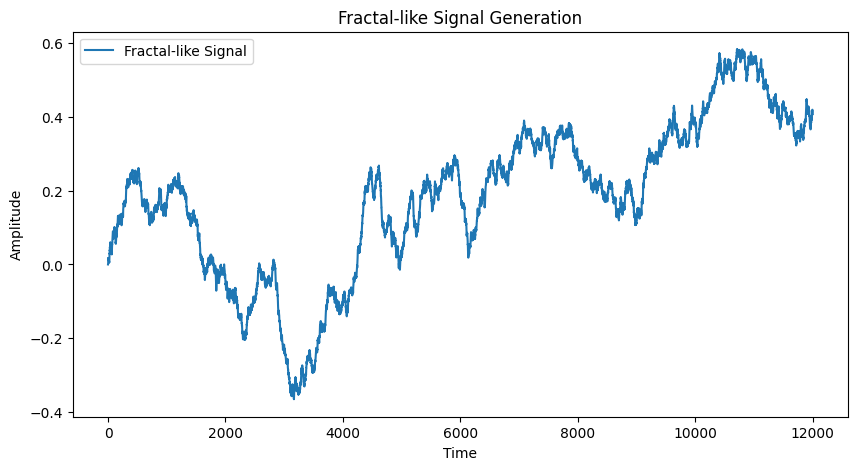

In [7]:

from fbm import FBM

# Function to generate fractal-like signal
def generate_fractal_like_signal(n, hurst):
    f = FBM(n=n, hurst=hurst, length=1.0, method='daviesharte')
    fractal_like_signal = f.fbm()

    return fractal_like_signal

# Set the length of the signal
n = len(z)

# Generate fractal-like signal
hurst_parameter = 0.6  # Adjust the hurst parameter as needed (0.5 < hurst < 1.0)
fractal_like_signal = generate_fractal_like_signal(n, hurst_parameter)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(fractal_like_signal, label='Fractal-like Signal')
plt.title('Fractal-like Signal Generation')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [8]:
class NotchFilter:
    def __init__(self, center_frequency, quality_factor, sample_rate):
        self.center_frequency = center_frequency
        self.quality_factor = quality_factor
        self.sample_rate = sample_rate
        self.nyquist = 0.5 * sample_rate
        self.frequency = center_frequency / self.nyquist

        # Design the notch filter
        self.b, self.a = iirnotch(self.frequency, quality_factor)

    def apply_filter(self, data):
        # Apply the notch filter to the data
        filtered_data = lfilter(self.b, self.a, data)
        return filtered_data

In [35]:
sample_rate = 2000 # Hz
duration = 1 # seconds
noise =  fractal_like_signal
center_frequency = 500  # Hz
quality_factor = 30
notch_filter = NotchFilter(center_frequency, quality_factor, sample_rate)
filtered_signal1 = notch_filter.apply_filter(filtered_signal)

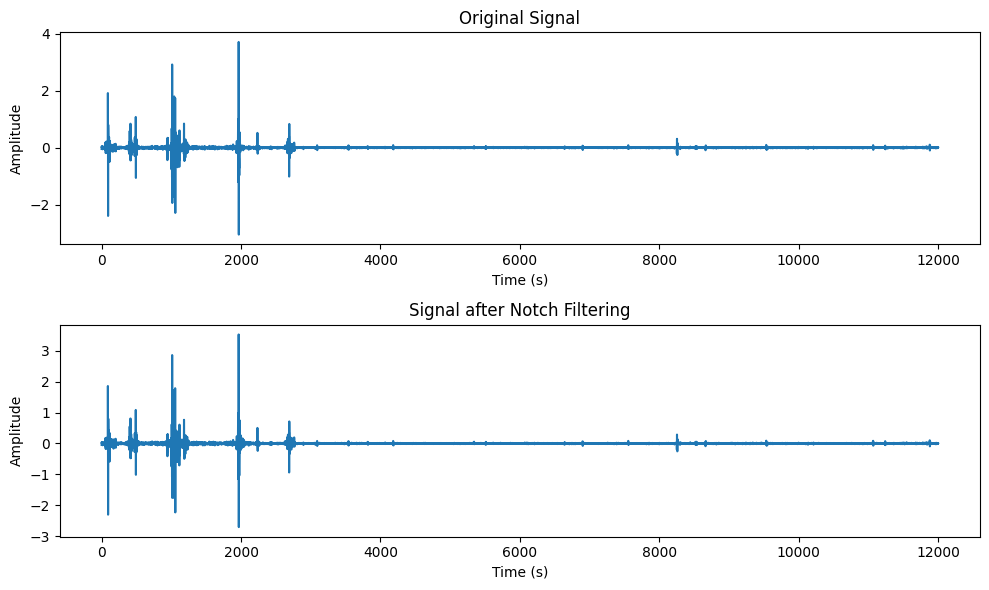

In [37]:
# Plot the original signal and the filtered signal
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(filtered_signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot( filtered_signal1)
plt.title('Signal after Notch Filtering')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [38]:
# Define the CNN architecture
class SimpleCNN:
    def __init__(self, num_filters, kernel_size, input_shape):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.input_shape = input_shape
        self.weights = np.random.randn(num_filters, kernel_size)

    def forward(self, x):
        convolutions = np.array([np.convolve(x, filter, mode='valid') for filter in self.weights])
        return convolutions

# Generate a random input signal
input_signal = filtered_signal


# Create an instance of the CNN
cnn = SimpleCNN(num_filters=5, kernel_size=100, input_shape=(100,))
output = cnn.forward(input_signal)
# Perform a forward pass




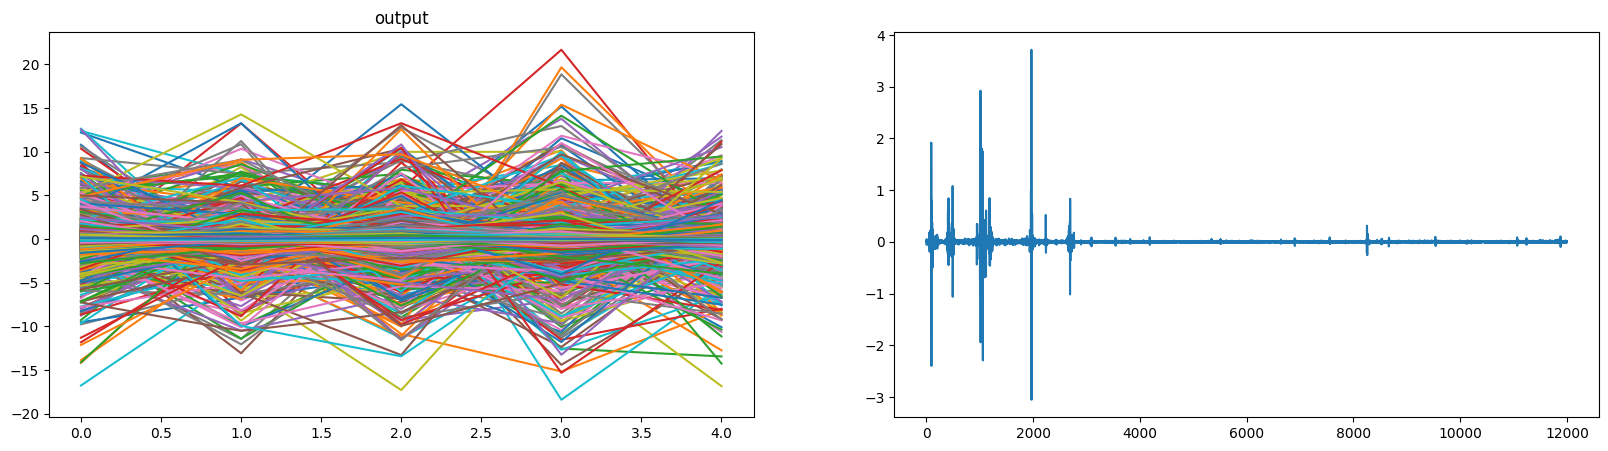

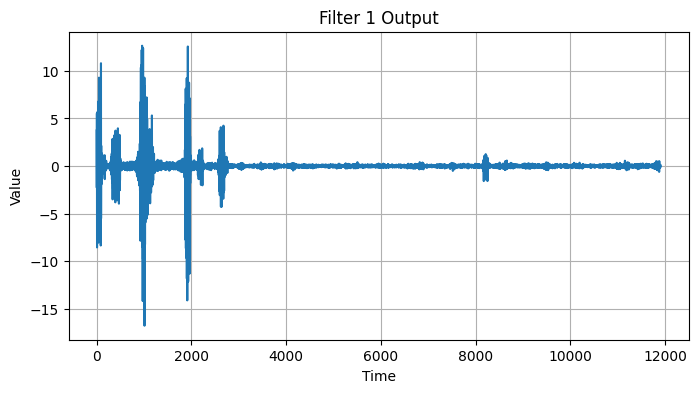

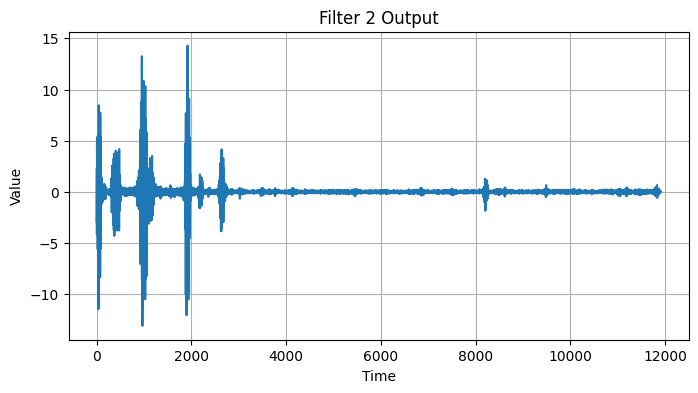

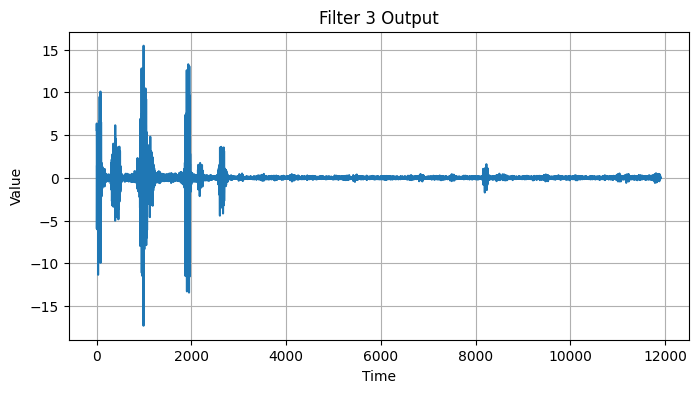

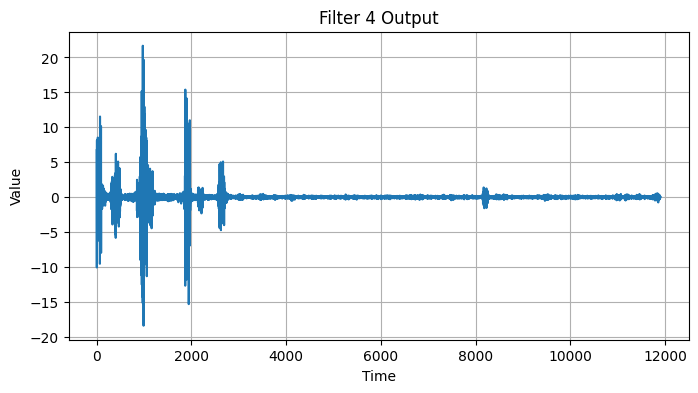

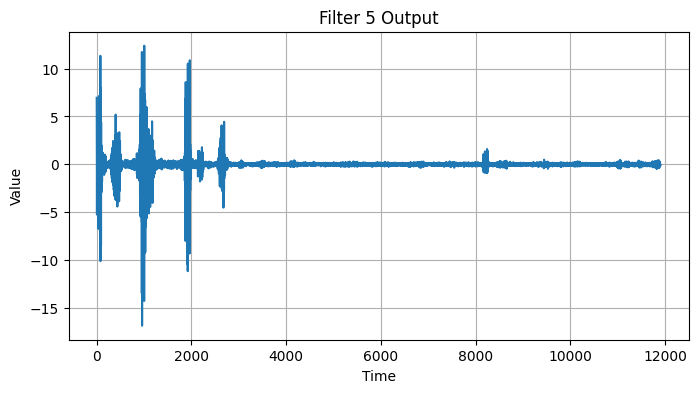

In [39]:

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(output)
plt.title('output')
plt.subplot(1,2,2)
plt.plot(input_signal)
#Create a plot for each filter's output
for i in range(output.shape[0]):
    plt.figure(figsize=(8, 4))
    plt.plot(output[i])
    plt.title(f"Filter {i+1} Output")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
# Show all the plots
plt.show()

#menghitung frekuensi noise

In [40]:
#menghitung signal to noise metode SNR

def calculate_snr(signal, noise):
    # Calculate the power of the signal
    signal_power = np.sum(np.square(signal))

    # Calculate the power of the noise
    noise_power = np.sum(np.square(noise))

    # Calculate SNR in decibels (dB)
    snr_db = 10 * np.log10(signal_power / noise_power)

    return snr_db

# Example usage:
# Assuming you have a signal and noise arrays
signal = np.array(input_signal)
noise = np.array(fractal_like_signal)

# Calculate SNR
snr_result = calculate_snr(signal, noise)

print(f"SNR: {snr_result} dB")


SNR: -9.288042599499066 dB


In [21]:
class DCNN:
    def __init__(self, input_shape, num_filters, kernel_size, pool_size, num_classes, filename,learning_rate):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.num_classes = num_classes
        self.filters = np.random.randn(num_filters, kernel_size)
        self.bias = np.zeros(num_filters)
        self.fc_weights = np.random.randn(num_filters, num_classes)
        self.fc_bias = np.zeros(num_classes)
        self.filename = filename
        self.learning_rate=learning_rate

    def forward(self, x):
        conv_output = []
        for i in range(self.num_filters):
            filter_output = np.convolve(x.squeeze(), self.filters[i], mode='valid') + self.bias[i]
            pool_output = np.max(np.array_split(filter_output, len(filter_output) // self.pool_size))
            conv_output.append(pool_output)

        fc_input = np.array(conv_output)
        fc_output = np.dot(fc_input, self.fc_weights) + self.fc_bias
        return fc_output, fc_input

    def mse_loss(self, predicted, target):
        return np.mean((predicted - target) ** 2)

    def mse_loss_gradient(self, predicted, target):
        return 2 * (predicted - target) / len(target)

    def cross_entropy_loss(self, predicted, target):
        epsilon = 1e-15
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        return -np.sum(target * np.log(predicted))

    def cross_entropy_loss_gradient(self, predicted, target):
        epsilon = 1e-15
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        return -target / predicted
    def accuracy(self, predicted, target):
        correct_predictions = np.sum(np.argmax(predicted, axis=1) == np.argmax(target, axis=1))
        total_samples = len(target)
        accuracy = correct_predictions / total_samples
        return accuracy

    def backward(self, x, target, loss_function='mse'):
        predicted, fc_input = self.forward(x)

        # Backpropagation for the fully connected layer
        if loss_function == 'mse':
            loss = self.mse_loss(predicted, target)
            fc_error = self.mse_loss_gradient(predicted, target)
        elif loss_function == 'cross_entropy':
            loss = self.cross_entropy_loss(predicted, target)
            fc_error = self.cross_entropy_loss_gradient(predicted, target)
        else:
            raise ValueError("Invalid loss function")

        fc_delta = fc_error
        self.fc_weights -= self.learning_rate * np.outer(fc_input, fc_delta)
        self.fc_bias -= self.learning_rate * fc_delta

        # Backpropagation for the convolutional layer
        conv_error = np.dot(fc_delta, self.fc_weights.T)
        for i in range(self.num_filters):
            self.filters[i] -= self.learning_rate * np.convolve(x.squeeze(), np.flip(conv_error[:, i]), mode='valid')
            self.bias[i] -= self.learning_rate * np.sum(conv_error[:, i])

        return loss

    def train(self, x, target, loss_function='mse'):
        predicted = self.forward(x)[0]
        loss = self.backward(x, target, loss_function)
        return loss

    def save_model(self):
        model_params = {
            'input_shape': self.input_shape,
            'num_filters': self.num_filters,
            'kernel_size': self.kernel_size,
            'pool_size': self.pool_size,
            'num_classes': self.num_classes,
            'filters': self.filters.tolist(),
            'bias': self.bias.tolist(),
            'fc_weights': self.fc_weights.tolist(),
            'fc_bias': self.fc_bias.tolist(),
        }

        with open(self.filename, 'wb') as file:
            pickle.dump(model_params, file)

    def load_model(self):
        with open(self.filename, 'rb') as file:
            model_params = pickle.load(file)

        self.input_shape = model_params['input_shape']
        self.num_filters = model_params['num_filters']
        self.kernel_size = model_params['kernel_size']
        self.pool_size = model_params['pool_size']
        self.num_classes = model_params['num_classes']
        self.filters = np.array(model_params['filters'])
        self.bias = np.array(model_params['bias'])
        self.fc_weights = np.array(model_params['fc_weights'])
        self.fc_bias = np.array(model_params['fc_bias'])


(array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan]))


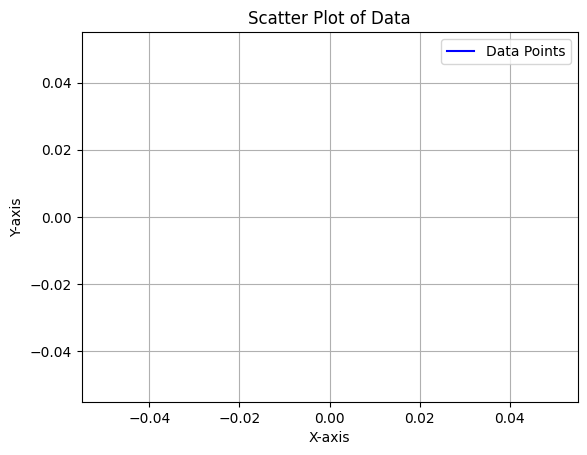

In [22]:
input_signal = filtered_signal1 # Replace this with your actual input signal
input_shape = len(input_signal)
num_filters = 16
kernel_size = 9
pool_size = 2
learning_rate=0.01
num_classes = len(input_signal)
target_labels = np.random.randint(0, num_classes, size=(1, num_classes))
filename = '/media/fathur/THESIS/sensor/delmodel/delmodel.pkl'
cnn_model = DCNN(input_shape, num_filters, kernel_size, pool_size, num_classes,filename,learning_rate)

# Perform a forward pass
output1 = cnn_model.forward(input_signal)

# Save the model
cnn_model.save_model()


print(output1)
x = output1[0]
y =output1[1]
# Plot the data
plt.plot(x, color='blue', label='Data Points')
#plt.plot(y) #fungsi loss
plt.title('Scatter Plot of Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
loss = cnn_model.train(input_signal, target_labels)

# Calculate accuracy
accuracy = cnn_model.accuracy(predicted_output, target_labels)
print("Accuracy:", accuracy)


ValueError: non-broadcastable output operand with shape (12000,) doesn't match the broadcast shape (1,12000)

test data dari model

Loaded Model Output:
(array([-21.30356286,  24.08204609,  13.92397059, ...,  -2.23307589,
        39.69856584, -27.40931027]), array([ 7.00056902,  7.21015653,  6.95168528,  9.06984257,  8.55584198,
       10.03365638,  7.7031068 ,  4.13272772,  7.8824714 ,  5.56639187,
        4.11373886,  8.32670985,  8.4317203 ,  8.28308157,  6.07396666,
        7.83247775]))


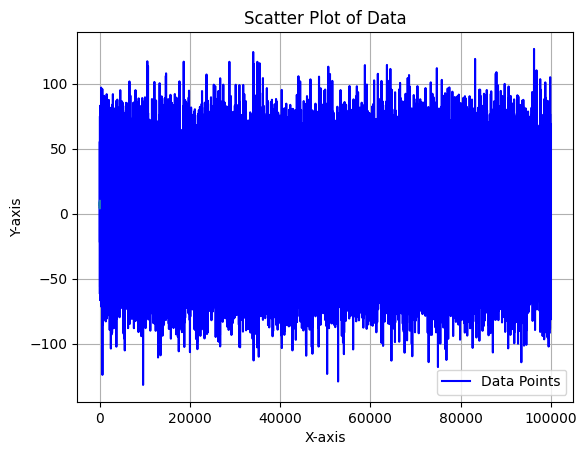

In [150]:
filename = '/media/fathur/THESIS/sensor/delmodel/delmodel.pkl'
loaded_cnn_model = DCNN(input_shape, num_filters, kernel_size, pool_size, num_classes, filename,learning_rate)  # Provide temporary values for input parameters
loaded_cnn_model.load_model()

# Test the loaded model
input_signal = np.random.randn(100)  # Replace this with your actual input signal
loaded_output = loaded_cnn_model.forward(input_signal)

print("Loaded Model Output:")
print(loaded_output)
x = loaded_output[0]
y =loaded_output[1]
# Plot the data
plt.plot(x, color='blue', label='Data Points')
plt.plot(y)
plt.title('Scatter Plot of Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

segmentasi + convolusi machine learning biasa

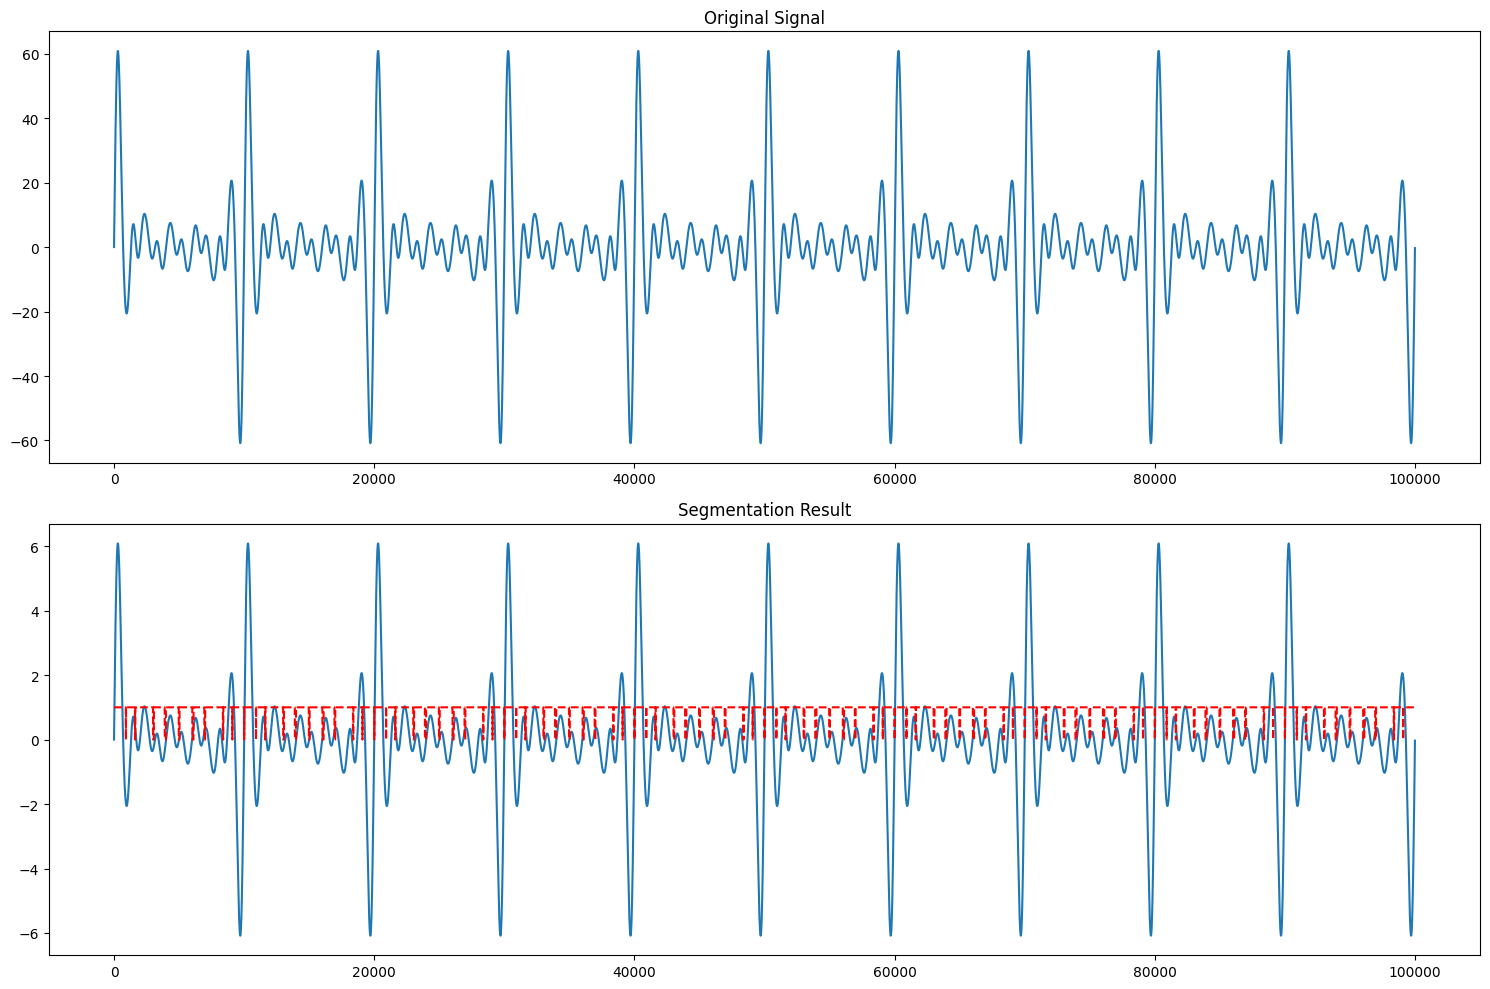

In [154]:


signal_length = len(seismic_signal)
signal = seismic_signal

# Apply convolution for smoothing
window_size =1000
smoothed_signal = np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# Set a threshold for segmentation
threshold = 0.3

# Perform segmentation based on the threshold
segmentation = np.abs(smoothed_signal) > threshold

# Plot the original signal, smoothed signal, and segmentation result
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(seismic_signal*0.1)
plt.plot(segmentation,color='r',linestyle='--')
plt.title('Segmentation Result')

plt.tight_layout()
plt.show()



In [155]:
class DDCC:
    def __init__(self, signal_length=len(seismic_signal), threshold=0.5, epochs=100, kernel_size=500, num_filters=8):
        self.signal_length = signal_length
        self.threshold = threshold
        self.epochs = epochs
        self.trained_threshold = None
        self.kernel_size = kernel_size
        self.num_filters = num_filters

    def generate_sample_signal(self):
        # Assuming filtered_signal1 is defined
        return seismic_signal

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting np.max(x) for numerical stability
        return exp_x / exp_x.sum(axis=0, keepdims=True)

    def relu(self, x):
        return np.maximum(0, x)

    def segment_signal(self, signal):
        return (signal > self.threshold).astype(int)

    def train_model(self, signal):
        self.trained_threshold = np.mean(signal)

    def convolution(self, signal, kernel):
        result = np.zeros_like(signal)
        for i in range(len(signal) - self.kernel_size + 1):
            conv_result = np.sum(signal[i:i+self.kernel_size] * kernel)
            result[i] = self.relu(conv_result)  # Apply ReLU to the convolution result
        return result

    def make_predictions(self, new_signal):
        if self.trained_threshold is None:
            raise ValueError("Model not trained. Please run train_model first.")
        
        # Implement a simple convolution operation
        kernel = np.random.rand(self.kernel_size)
        convolved_signal = self.convolution(new_signal, kernel)

        # Apply softmax to the output
        predictions = self.softmax(convolved_signal - self.trained_threshold)
        return predictions

    def plot_results(x,predictions):
        n = min(x.shape[0], 5)  # Number of samples to visualize
        plt.figure(figsize=(24, 15))
        for i in range(n):
            # Original Signal
            plt.subplot(3, n, i + 1)
            plt.plot(x[i].flatten(), color='blue', label='Original Signal')
            plt.title('Original Signal')

            # Ground Truth
            plt.subplot(3, n, i + 1 + n)
            plt.plot(x[i].flatten(), color='green', label='Ground Truth')
            plt.title('Ground Truth')

            # Predicted Signal
            plt.subplot(3, n, i + 1 + 2 * n)
            plt.plot(predictions[i].flatten(), color='red', label='Predicted Signal')
            plt.title('Predicted Signal')
        plt.show()

    def run_classification(self):
        # Generate sample signal
        signal = self.generate_sample_signal()

        # Segment the signal
        segmented_signal = self.segment_signal(signal)

        # Train the model (thresholding approach)
        self.train_model(signal)

        # Make predictions on new data
        new_signal = self.generate_sample_signal()
        predictions = classifier.make_predictions(new_signal)

        print(predictions)

# Create an instance of the DDCC class
classifier = DDCC()

# Run the signal classification
classifier.run_classification()

# Make predictions on new data
new_data = classifier.generate_sample_signal()
predictions = classifier.make_predictions(new_data)
print(predictions)


[3.17044877e-293 5.61239738e-285 7.55632236e-277 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
[0.000000e+000 0.000000e+000 9.737056e-318 ... 0.000000e+000 0.000000e+000
 0.000000e+000]


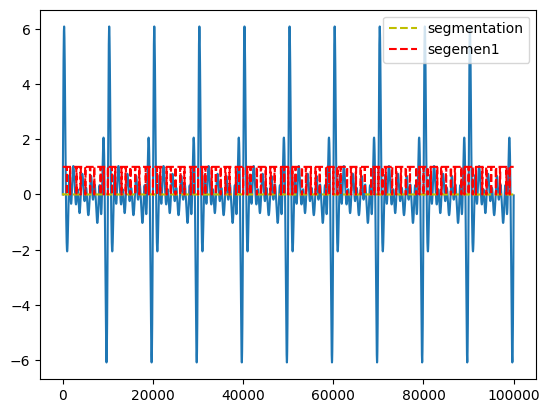

In [158]:
hasil=np.array(predictions)
plt.plot(seismic_signal*0.1)
plt.plot(hasil,label='segmentation',linestyle='--',color='y')
plt.plot(segmentation,linestyle='--',color='r',label='segemen1')
plt.legend()
plt.show()

0.0
0.0
9.737056e-318
2.986554225585583e-309
7.01873134079105e-301
1.263635605021429e-292
1.7425828420812093e-284
1.8403924211002247e-276


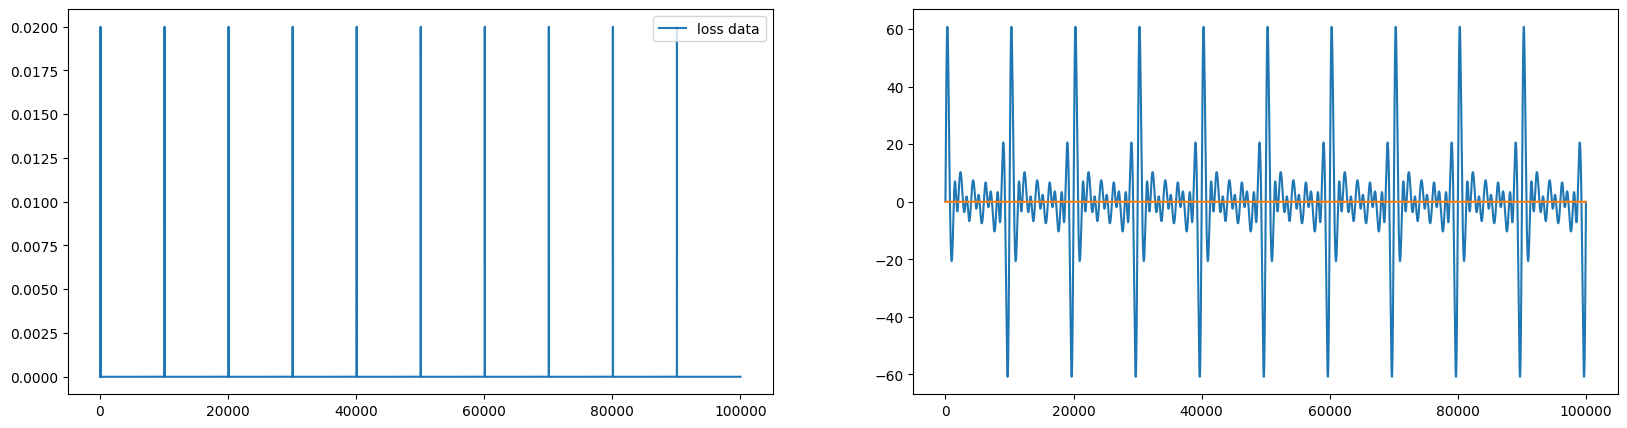

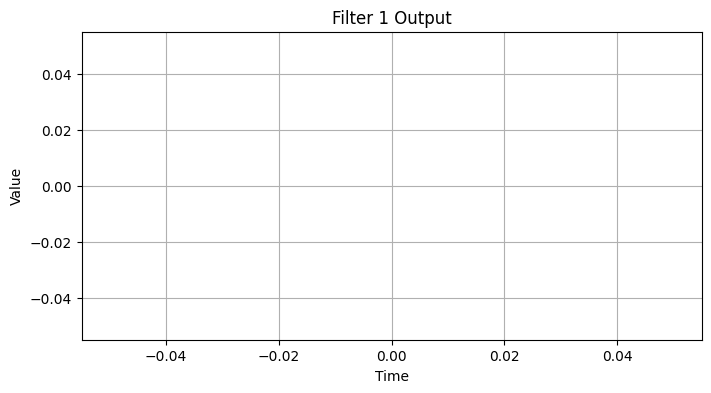

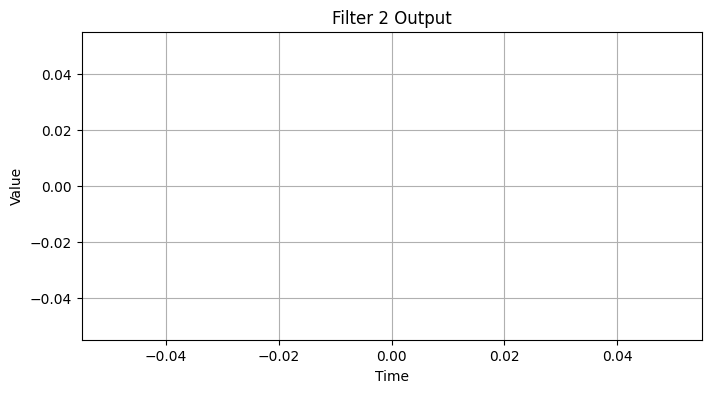

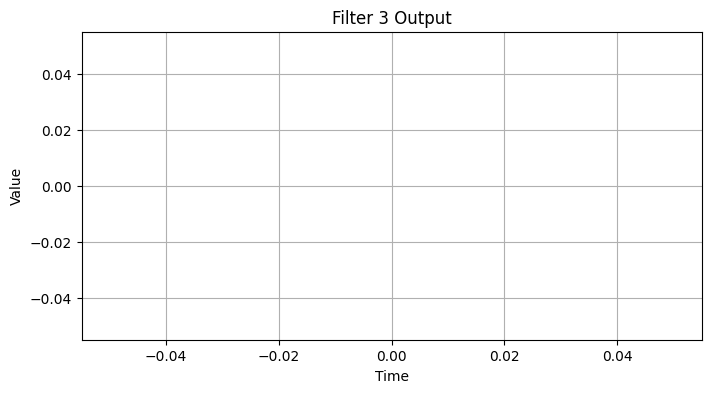

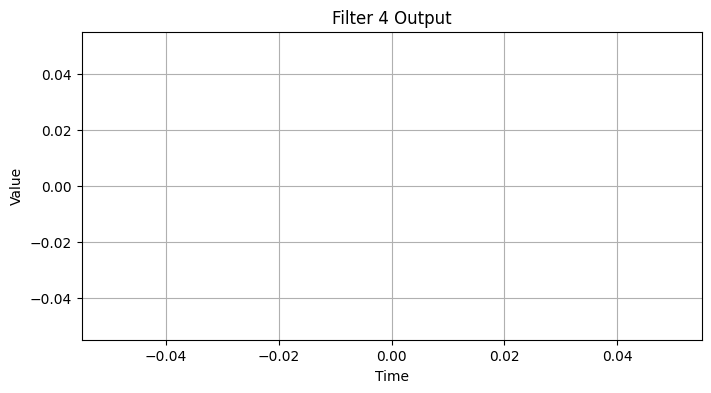

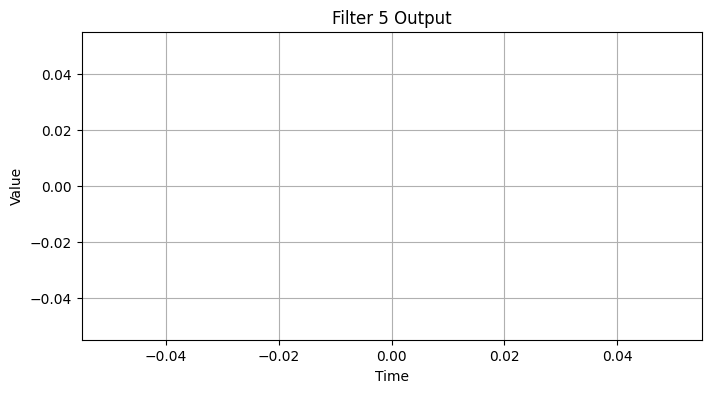

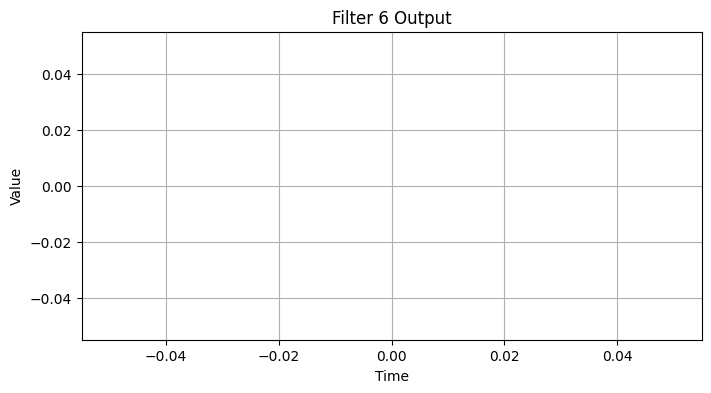

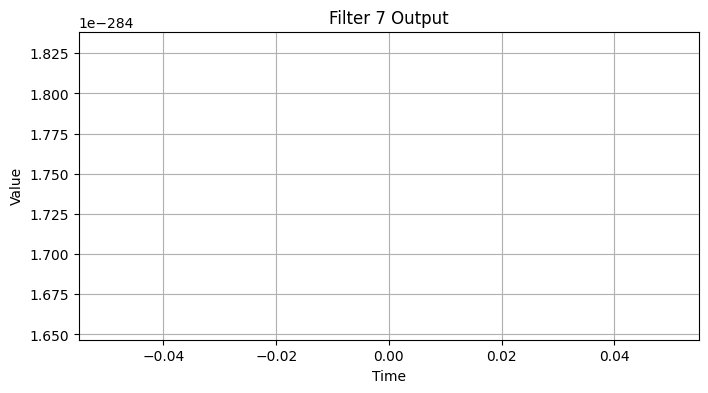

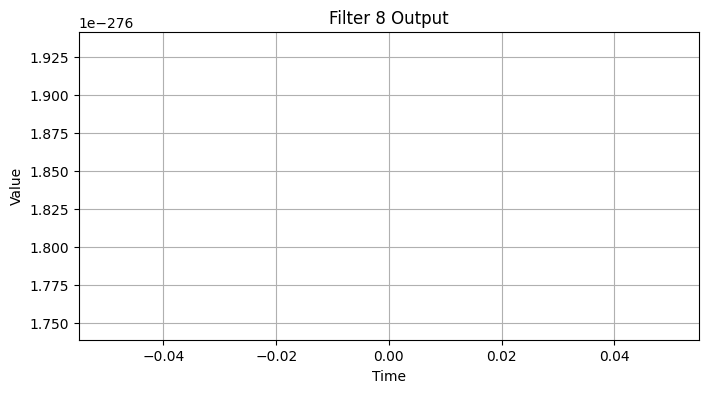

In [165]:

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(hasil,label='loss data')
plt.legend()
plt.subplot(1,2,2)
plt.plot(seismic_signal)
plt.plot(hasil)
#Create a plot for each filter's output
for i in range(8):
    plt.figure(figsize=(8, 4))
    plt.plot(hasil[i])
    print(predictions[i])
    plt.title(f"Filter {i+1} Output")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Show all the plots
plt.show()

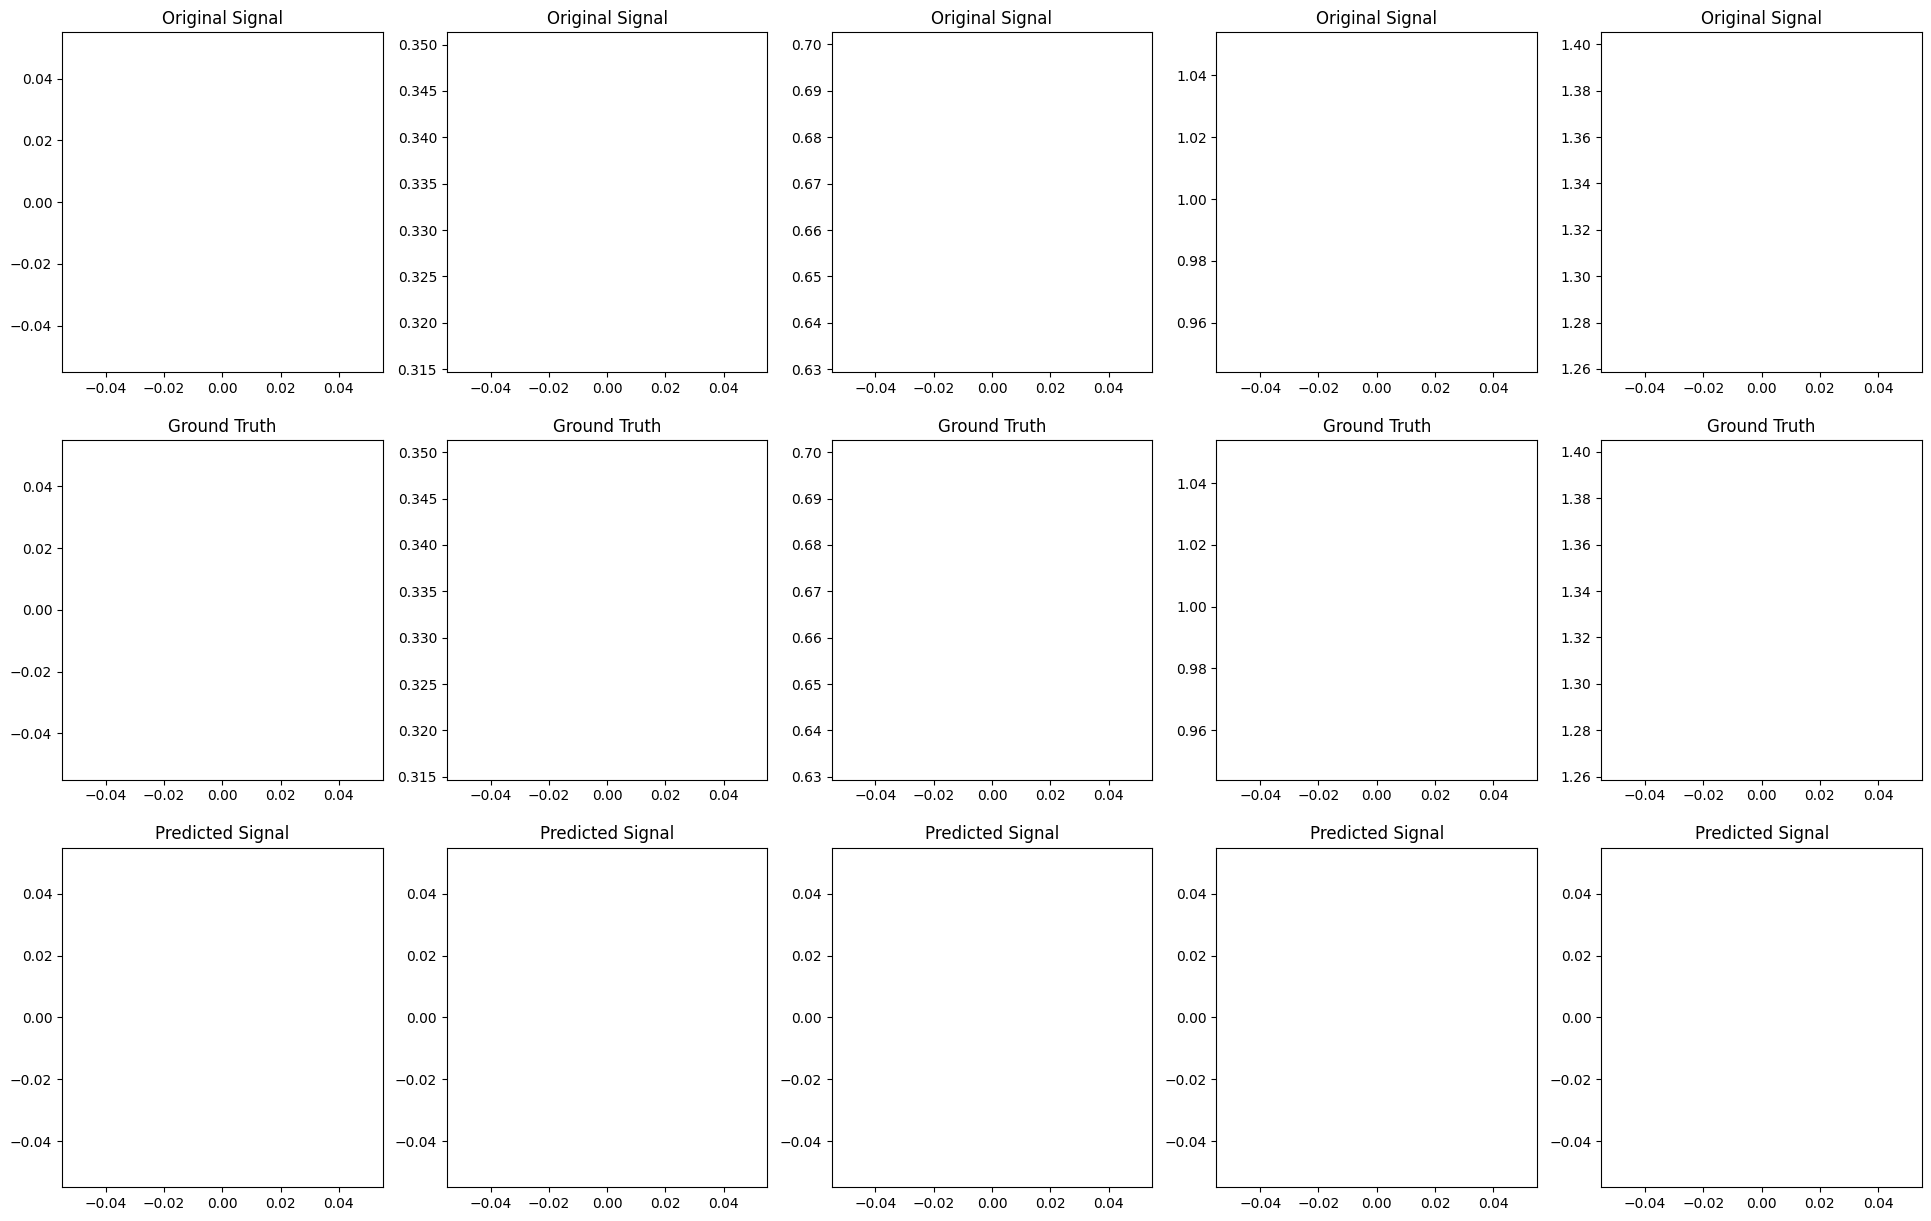

In [164]:
DDCC.plot_results(np.array(seismic_signal),hasil)